# Introduction: determining stock sector from stock behaviour

In the next notebook you will be given the history of stock prices for anonymous stocks and we will use a combination of PCA and Boosting to assign each stock to it's most likely sector. If you are new to stock price analysis this might seem like complete magic. However, as we you will see, the predictions are based on a common sense understanding of the behaviour of stock prices. Much of the analysis has been done, your job is to fill in the missing parts correctly.

* In this notebook we will focus on preparing informative features using PCA.
* In the next notebook we will use Boosted decision trees to predict the sector from the values of the features.

### Create a Spark context and import dependencies

In [1]:
import pyspark
from pyspark import SparkContext

sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
import pickle

from spark_PCA import computeCov

Populating the interactive namespace from numpy and matplotlib


### Read data

Read the file `SP500.csv` into a `Spark` dataframe.

In [2]:
# read the file in a dataframe.
df=sqlContext.read.csv('data/SP500.csv',header='true',inferSchema='true')
columns=df.columns
col=[c for c in columns if '_D' in c]

### Visualize using Pandas
To visualize the data we transform the `Spark` DataFrame to a `pandas` DataFrame. 

(((You don't need to know pandas to complete this final. However, if you are interested, you can take the first class in this micro-masters: DSE200x: Python for data analysis.)))

In [3]:
Diffs=df.toPandas()
Diffs=Diffs.set_index('Date')
Diffs.tail(3)

,train/AAPL_D,train/AAPL_P,train/ABC_D,train/ABC_P,train/ABT_D,train/ABT_P,train/ACN_D,train/ACN_P,train/ADBE_D,train/ADBE_P,...,test/86_D,test/86_P,test/87_D,test/87_P,test/88_D,test/88_P,test/8_D,test/8_P,test/9_D,test/9_P
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-13,-0.010730,128.37,-0.008448,115.31,-0.005788,46.78,-0.008195,94.34,-0.005510,76.44,...,-0.003119,41.74,-0.012336,39.15,NaN,NaN,-0.004147,72.50,-0.004290,84.10
2015-04-14,-0.004656,127.00,-0.001225,114.34,0.006430,46.51,0.007453,93.57,0.000920,76.02,...,0.015264,41.61,0.019970,38.67,NaN,NaN,0.002490,72.20,-0.000956,83.74
2015-04-15,-0.001029,126.41,-0.006942,114.20,-0.004282,46.81,-0.003826,94.27,-0.008977,76.09,...,0.000946,42.25,0.013845,39.45,NaN,NaN,0.001381,72.38,-0.007920,83.66


### Explanation of the table
* The rows of the table are indexed by date. Starting in 1962, a time when most of the stocks we are tracking did not exist, and ending in 2015.
* The columns come in pairs `XXX/YYY_P` and `XXX/YYY_D`. The prefix `XXX = train` for stocks whose *ticker* is `YYY` or  `XXX=test` for stocks whose ticker (and sector) are hidden. `YYY` for test columns is an integer index.
   * The columns ending with `_P` give the **Adjusted Open Price** of stocks, which are the prices when the stock exchange opens in the morning. We use the **adjusted** prices which eliminate technical adjustments such as stock splits.
   * The columns ending with `_D` are the log price ratio, as described below



### A naive plot of stocks.
To get started, we plot the stock prices.

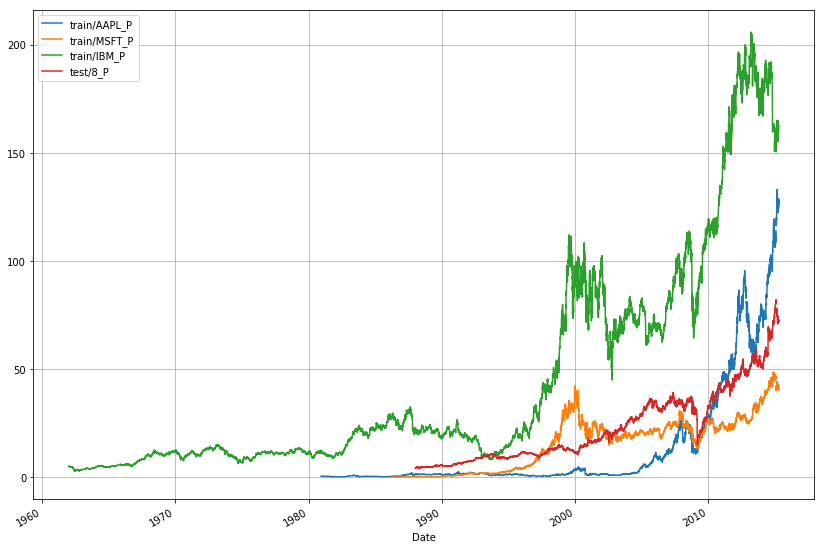

In [4]:
# plot some stocks
Diffs[['train/AAPL_P','train/MSFT_P','train/IBM_P','test/8_P']].plot(figsize=(14,10));
plt.grid()

### A few observations

* Most of the stock grow over the long term, however, on the short term, their prices fluctuate significantly.
* Suppose $p_s(t)$ is the price of stock $s$ on day $t$. It does not make much sense to consider **additive** changes to the stock price: $p(t+1)-p(t)$ becuase the changes in price of, say **IBM** around 1980 is much smaller than than change of the same stock around 2010. Instead, it makes more sense to consider the **relative** change in prices: $\frac{p(t+1)}{p(t)}$.
* As it is convenient to make the price changes **additive** it makes sense to replace $\frac{p(t+1)}{p(t)}$ with $\log\frac{p(t+1)}{p(t)}$.
   * This allows us to write $\frac{p(t+k)}{p(t)} = \sum_{i=1}^k \log \frac{p(t+i)}{p(t+i-1)}$
* Unlike the price, whose value can change a lot between different times. The **log price ratio** $\log\frac{p(t+1)}{p(t)}$ is always close to zero: it is slightly above 0 if the price increased on a particular day and is slightly negative if it decreased.

To strengthen your intuition in this regard, consider **Black Monday**:

### Black Monday

One of the biggest crashes in the US stock market happened on
**Black Monday:** Oct 19 1987  

We will look at the stocks around that date

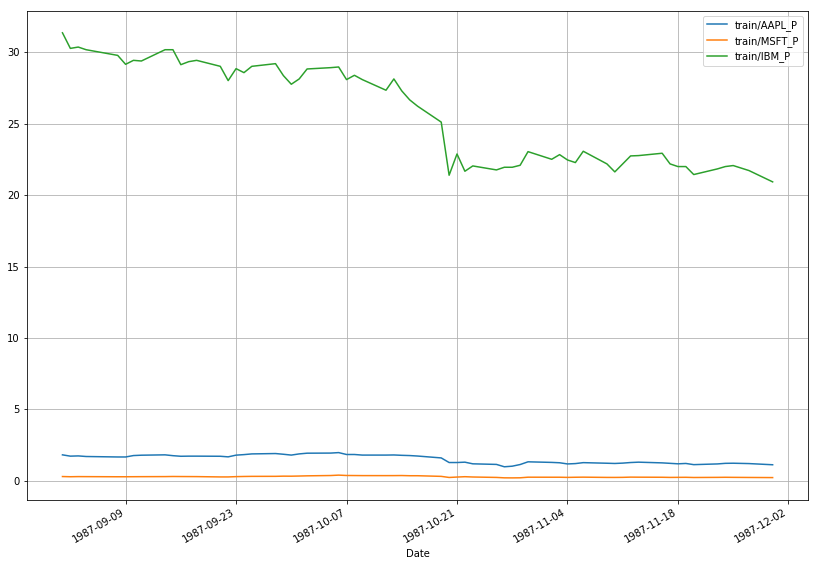

In [5]:
#Focus on "Black Monday:" the stock crash of Oct 19 1987

import datetime
format = "%b-%d-%Y"

_from = datetime.datetime.strptime('Sep-1-1987', format)
_to = datetime.datetime.strptime('Nov-30-1987', format)

Diffs.loc[_from:_to,['train/AAPL_P','train/MSFT_P','train/IBM_P']].plot(figsize=(14,10));
plt.grid()

**Why does it seems that the price of IBM fell much more than those of Apple and microsoft?**

Because IBM's price started so much higher. As explained above it is more informative to consider $\log\frac{p(t+1)}{p(t)}$

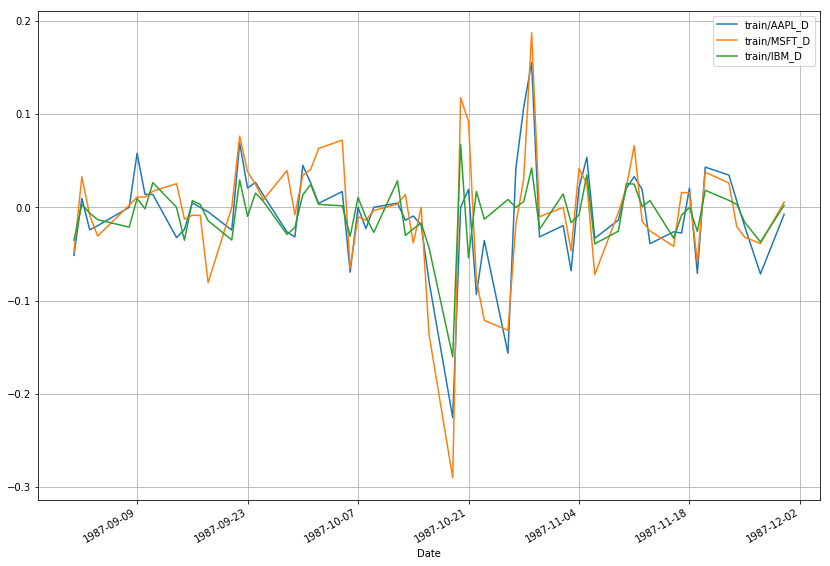

In [6]:
Diffs.loc[_from:_to,['train/AAPL_D','train/MSFT_D','train/IBM_D']].plot(figsize=(14,10));
plt.grid()

**Observe:** while it is hard to see the effect of the crash when considering the actual prices, plotting the log price ratio makes it clear that On october 19 all stocks went down significantly. Moreover, if you look at surrounding dates, indeed, if you look at **any** dates, you see that the price changes are highly correlated with each other, which, as we will explained below, is the rationale behind using **PCA** to relate the stocks.

Interestingly, the stocks regained most of the loss in the on Oct 20th, which shows that it is never a good idea to sell at a panic. *However* it is also not true that the stock market came back to where it was before the crash, that took much longer.

## Analysis of stock prices using Principal Component Analysis 
As you observe in the graphs above, the stock prices around black monday are highly correlated. This is hardly surprising, as that was a day where traders, and the public at large, have lost faith in the market and, in their panic, tried to sell their stocks, creating a snowball effect.

Luckily, such crashes are rare. However, the stock market is always volatile. The market reacts quickly to news and reflects their expected effect in the stock prices. Importantly, different news affect different sectors of the market in different ways. News related to home construction will affect the price of Real-Estate based stocks which news regarding changes in health-care policy will affect the health-care industry.

In fact **even without knowing what is the common cause** we can use the correlations between stocks to identify stocks that belong to the same sector. This is where **PCA** comes into play. Finding the dominant eigenvectors of the log-price-ratio number will allow us to map the stocks into a low dimensional space in which stocks with similar dependencies on outside factors will be close to each other.

#### Read data

Here, we read `Tickers.pkl` which is a dictionary with the keys: `Tickers` and `TickerInfo`. 

`Tickers` contains the ticker names and `TickerInfo` is a Pandas dataframe containing Company name, Sector and SectorID for each ticker.

We will use this table in the second notebook to define the label (sector) for each of the training stocks.

In [7]:
import pandas as pd
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
print("How many companies do we have? : {0}".format(TickerInfo.shape[0]))
TickerInfo.head(5)


How many companies do we have? : 505


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


### Partition Columns

In [8]:
#Extract the price/ratio columns(ending with _D)
#and partition those columns of df into a training set and a test set, each sorted alphabetically.
def partition_columns(df):
    train_col=[]
    test_col=[]
    columns=df.columns
    col=[c for c in columns if '_D' in c]
    for i in range(len(col)):
        if 'train' in col[i]:
            train_col.append(col[i])
        else:
            test_col.append(col[i])
    train_col = sorted(train_col)
    test_col=sorted(test_col)
    return  train_col+test_col

In [9]:
columns = partition_columns(df)
df=df.select(columns)

### Create an RDD of numpy arrays
In order to use the module `lib/spark_PCA.py` you need to transform the dataframe `df` into an RDD of numpy vectors.

#### Function `make_array`
Complete the function `make_array(row)` that takes as input a row of `df` and returns a numpy array (`dtype=np.float64`) that contains the values stored in the `col` firelds of the Row. Use `np.nan_to_num` to transform `nan`s into zeros.

* Direct Input: A row of real values
* Indirect input: col - defines the columns of df that are to be used.,

* Output: numpy array of diff columns

In [10]:
#the sequence of columns is define by the variable `col` in the immediate environment.
def make_array(row):
    ret=[]
    for val in row:
        if (val == None):
            val = 0.0
        ret.append(val)
    return np.nan_to_num(ret)

In [11]:
#visible test
row1_correct=pickle.load(open('data/row1.pkl','rb'))
rows=df.take(2)
col=columns
row1=make_array(rows[1])
assert (type(row1)==numpy.ndarray), "make_array did not return the correct type"
assert (row1==row1_correct).all(),"make_array did not return the correct array"

#### Create RDD
Use `map` to create an RDD of the numpy arrays specified by the columns `columns`. The name of the RDD would be `Rows`. 

In [12]:
#
# YOUR CODE HERE
#

# Remember that you need to use the Spark dataframe, not thee Pandas'.
Rows = df.rdd.map(make_array)

In [13]:
# TESTS
rowf = Rows.first()
assert type(Rows) == pyspark.rdd.PipelinedRDD, 'Incorrect return type'
assert type(rowf) == numpy.ndarray, 'Incorrect return type'
assert len(rowf) == 481, 'Incorrect dimensions'

In [14]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Compute covariance matrix

Here, we compute the covariance matrix of the data using `computeCov` in `spark_PCA.py`. The covariance matrix is of dimension `481 x 481`

In [15]:
OUT=computeCov(Rows)
OUT.keys()

dict_keys(['E', 'NE', 'O', 'NO', 'Cov', 'Mean', 'Var'])

### Computing eigenvalues and eigenvectors

In [16]:
from numpy import linalg as LA
def compute_eig(cov):
    eigval,eigvec=LA.eigh(cov)
    eigval=eigval[-1::-1] # reverse order
    eigvec=eigvec[:,-1::-1]
    return eigval, eigvec

In [17]:
eigval_all,eigvec_all = compute_eig(OUT['Cov'])

### Function `compute_PCA`

Complete the function `compute_PCA` that takes as input a list of tickers and computes the eigenvalues and eigenvectors.

Input: `tickers` - list of tickers

Output: `eigval`, `eigvec` - numpy arrays of eigenvalues and eigenvectors

Steps:
1. Given a list of tickers, create an RDD of numpy arrays using the `make_array` function, similar to `Create RDD` section above.
2. Using the `computeCov` function, compute the covariance matrix of the given list of tickers, similar to `Compute covariance matrix` section above. The object returned by `computeCov` is a dictionary with the `cov` key containing the covariance matrix.
3. Using the `compute_eig` function, compute the eigenvalues and eigenvectors of the covariance matrix obtained in step2 and store them in `eigval` and `eigvec` respectively

In [18]:
def compute_PCA(tickers):
    #
    # YOUR CODE HERE
    #    
    # The tickers parameter is a list of column names,
    # we get only those columns from Spark dataframe and create
    # a new RDD.
    tickersRdd = df[tickers].rdd
    
    # Note that since all columns are about the same measure (stocks),
    # we don't need to normalize values before applying PCA.
    # The other steps are the same from the function 
    # explanation above.
    arrayRdd = tickersRdd.map(make_array) # 1
    stats = computeCov(arrayRdd) # 2
    eigval, eigvec = compute_eig(stats['Cov']) # 3
    return eigval, eigvec

In [19]:
## Compute the PCA of the test vectors alone
col = [c for c in columns if 'test' in c]
eigval_test,eigvec_test=compute_PCA(col)

In [20]:
np.testing.assert_almost_equal(eigvec_test.dot(eigvec_test.T), eye(89), err_msg="eigvec_test not orthonormal")

In [21]:
eigval_c,eigvec_c=pickle.load(open('data/PCAtest1.pkl','rb'))

In [22]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [23]:
# HIDDEN TESTS
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [24]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Compute percentage-of-variance explained graph

In the cell below, write a function that plots the fraction of variance explained as a function of the number of top eigenvectors used. The function should return a numpy array where the value in location `i` is the fraction explained by the first `i+1` eigenvectors.

You should get a figure similar to this:

![percent-var-explained](figs/percentageOfVarianceExplained.png)

Hint:
1. Use the eigenvalues computed in `Compute eigenvalues and eigenvectors` section to plot the explained variance

In [25]:
# It seems that the eigenvalues are already in descending order.
print(eigval_all[0:10])
print(len(eigval_all))

[0.03051257 0.00537615 0.00337888 0.00321923 0.0018403  0.00158223
 0.00143948 0.00129675 0.00116353 0.00091295]
481


In [26]:
def var_explained(eigval):
    #
    # YOUR CODE HERE
    #
    explained = 0
    var_explained = []
    totalSum = sum(eigval)
    for val in eigval:
        explained = explained + val
        var_explained.append(explained / totalSum)
        
    return var_explained

cum=var_explained(eigval_all)
print(cum[:5])
print(cum[-1])

[0.2154120190244021, 0.25336645147606085, 0.27722061251724284, 0.2999476532626602, 0.3129397695478952]
1.0000000000000007


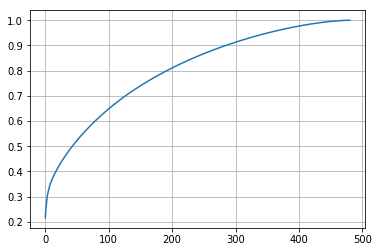

In [27]:
# Note how it starts increasing a lot and
# its growth goes decreasing, with 200 from 481 eigenvalues
# we can explain almost 80% of the variance.
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
xAxis = list(range(len(cum)))
ax.grid(True)
ax.plot(xAxis, cum)

In [28]:
assert abs(cum[-1] - 1) < 1e-8, 'The fraction of the variance explained by all eigenvectors is one'
for i in range(len(cum)-1):
    assert cum[i]<=cum[i+1], "cum cannot be decreasing"

In [29]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Saving the information for the next stage

In [30]:
from pickle import dump
dump({'columns':columns,
     'eigvec':eigvec_all,
     'eigval':eigval_all},
    open('data/PCA.pickle','wb'))
len(columns),eigvec_all.shape,eigval_all.shape

(481, (481, 481), (481,))

### Checking your calculations
One good way to check your calculations is to create a scatter-plot projecting the data on two of the largest variance eigenvectors.

In the directory `figs` you will find scatter plots corresponding to the six combinations of the top 4 eigenvectors.

In these scatter-plots the ticker is replaced by the sector ID.

Stocks from the same sector tend to have similar fluctuations. That is because they have similar sensitivities to costs (labor cost, energy) and profits (income distribution, holiday shopping). For example check out `figs/scatter.2.1.pdf` in which regions that are dominated by Finance, Energy or IT have been marked. 

In this section, you will create similar scatter plots and compare with those given. Your scatter-plots will be slightly different, because of the stocks you have eliminated, but spectral analysis is pretty robust, so your scatter plots should be quite similar (remember that the inverse of an eigenvector is also an eigenvector, so horizontal or vertical reflections of the scatter plot are meaningless).

#### Map tickers to Sector IDs

In [31]:
def map_sectorID(columns):
    NN=TickerInfo[['Ticker','SECTOR_ID']]
    Ticker2Sector={ a[1]:a[2] for a in NN.to_records()}
    sectors=[]
    unknown=known=0
    for i in range(len(columns)):
        ticker=columns[i]
        if ticker[1] == 'r':
            ticker = ticker[6:]
        else:
            ticker = ticker[5:]
        ticker = ticker[:-2]
        if ticker in Ticker2Sector:
            sectors.append(Ticker2Sector[ticker])
            known+=1
        else:
            sectors.append(ticker)
            unknown+=1
    return sectors, known, unknown

In [32]:
sectors, known, unknown = map_sectorID(columns)

#### Generate Scatter plots

Complete the function `Scatter_Stocks` to generate a scatter plot of the stocks on the given pair of eigenvectors. The function takes as input the indices of the two eigenvectors and generates a scatter plot of the data projected on the pair of eigenvectors.

Input: <br>
`eigvec` - Eigenvector<br>
`eigval` - Eigenvalue<br>
`i0`, `i1` - Eigenvector indices

Example Input: i0=0, i1=2 (eigenvectors 0 and 2 - eigvec[:, 0] and eigvec[:, 2])

Steps:
1. Using the `plt.subplots` function, set the figure size to (20, 20) in order that the stock ticker names are readable. Store the objects returned by `plt.subplots` in `fig` and `ax`
2. Set the X and Y axis limits to the minimum and maximum of the eigenvectors to be plotted on each axis using the `plt.xlim` and `plt.ylim` functions
3. Label the axes as follows: Coeff 0, Coeff 1, using `plt.xlabel` and `plt.ylabel`
4. for each ticker in `columns` that you generated in `Partition Columns` section, call the `ax.annotate` function in `matplotlib` using the `ax` object returned in `1` and annotate each point with the respective sectorID in `sectors`
5. The figure in `fig` is then saved according to the command given 

In [33]:
def Scatter_Stocks(eigval,eigvec,i0=0,i1=1):
    fig, ax = plt.subplots(figsize=(20,20));  # In order that the stock ticker names are readable we make the plot very large
    plt.xlim([np.amin(eigvec[:,i0]),np.amax(eigvec[:,i0])]);
    plt.ylim([np.amin(eigvec[:,i1]),np.amax(eigvec[:,i1])]);
    plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20);
    plt.xlabel('Coeff %d'%i0);
    plt.ylabel('Coeff %d'%i1);
    for i in range(len(columns)):
        ax.annotate(sectors[i], (eigvec[i,i0], eigvec[i,i1]),fontsize=10);
    
    fig.savefig('figs/scatter.'+str(i0)+'.'+str(i1)+'.pdf', format='PDF');
    # After exporting, we clear the figure so that the plot does not appear in the notebook.
    # fig.clear(); I commented this section to let the picture on notebook,
    # Different from the original notebook.
    return None

1 0
2 0
2 1
3 0
3 1
3 2


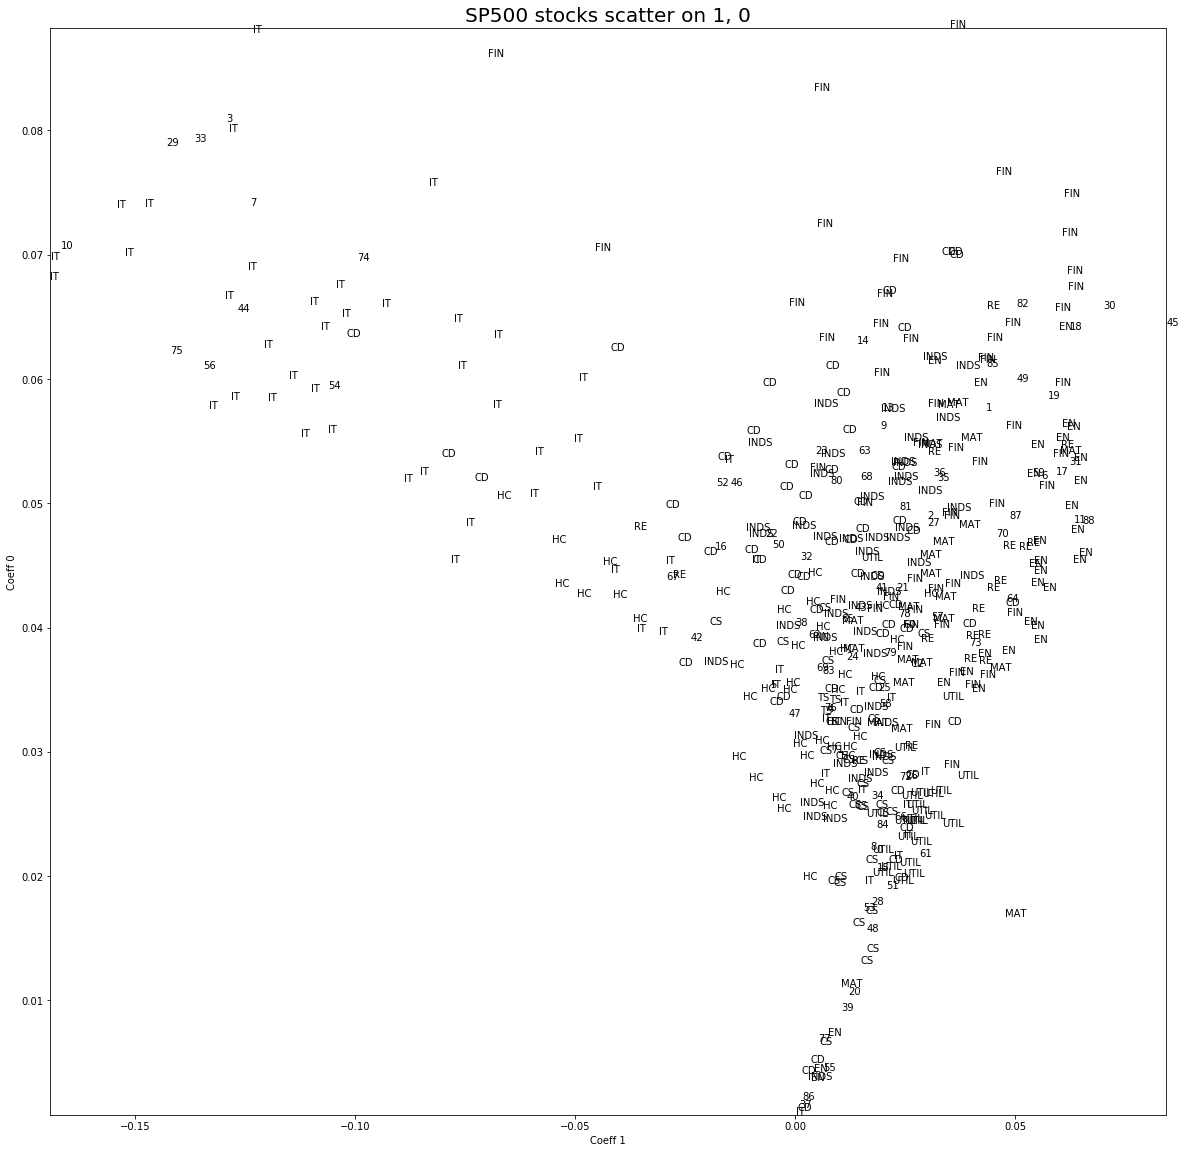

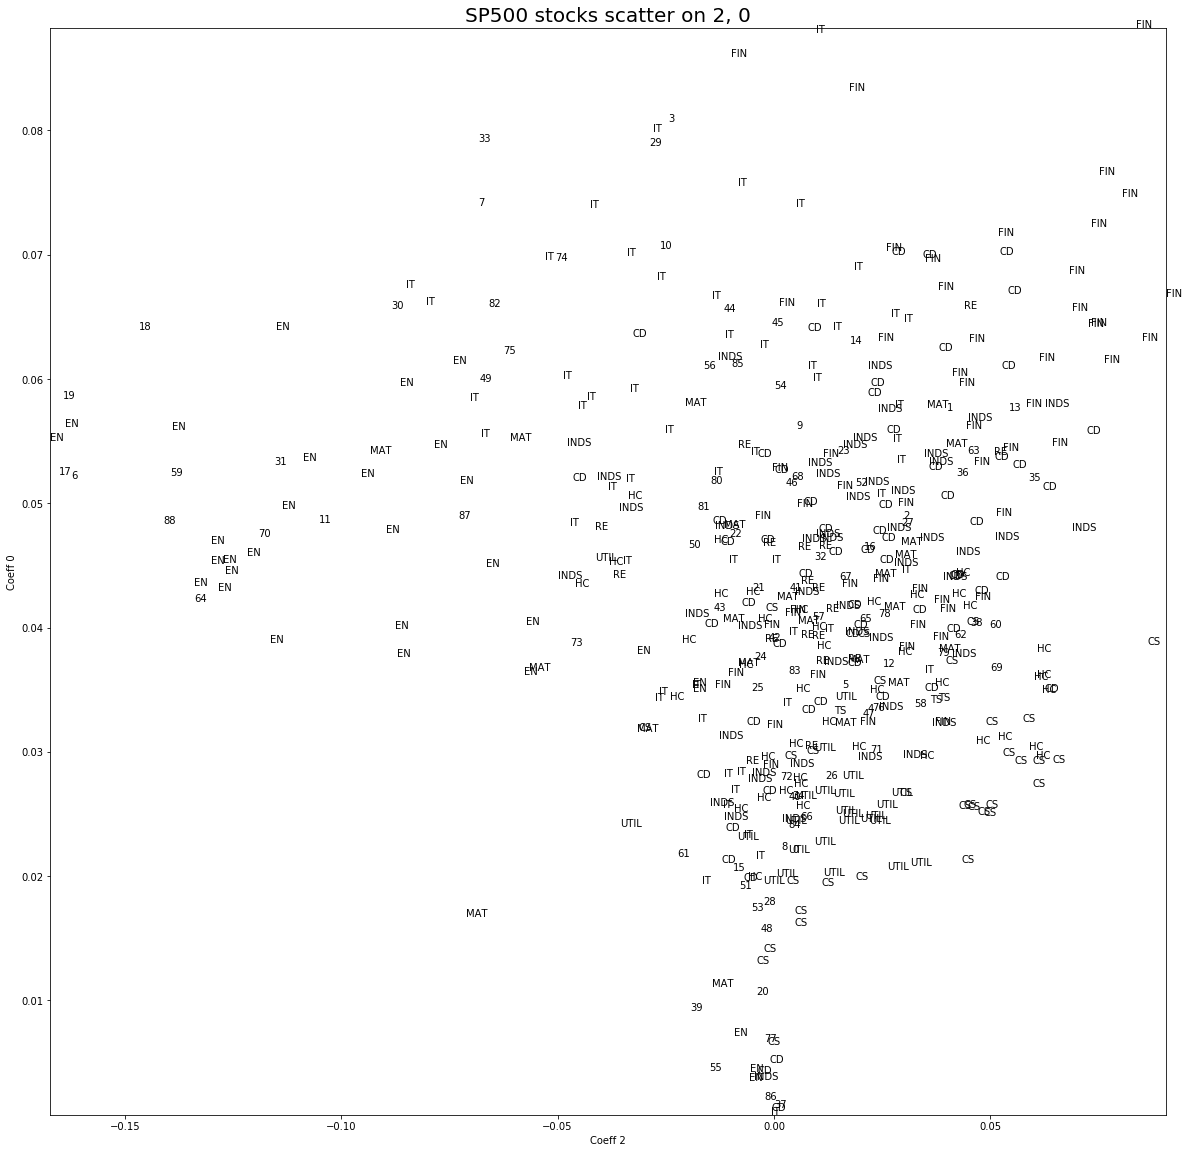

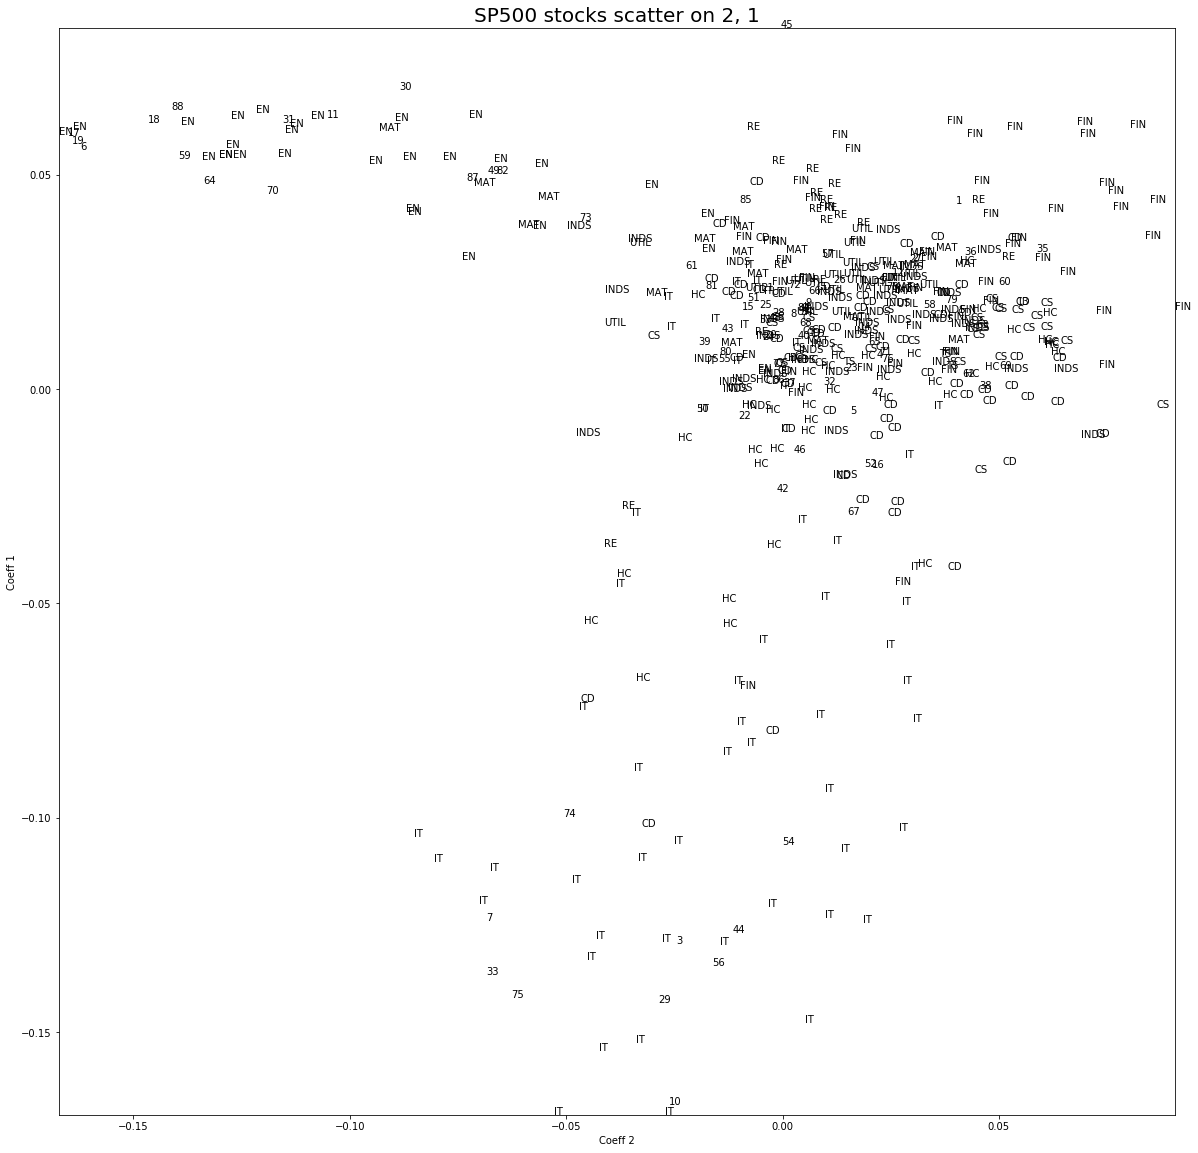

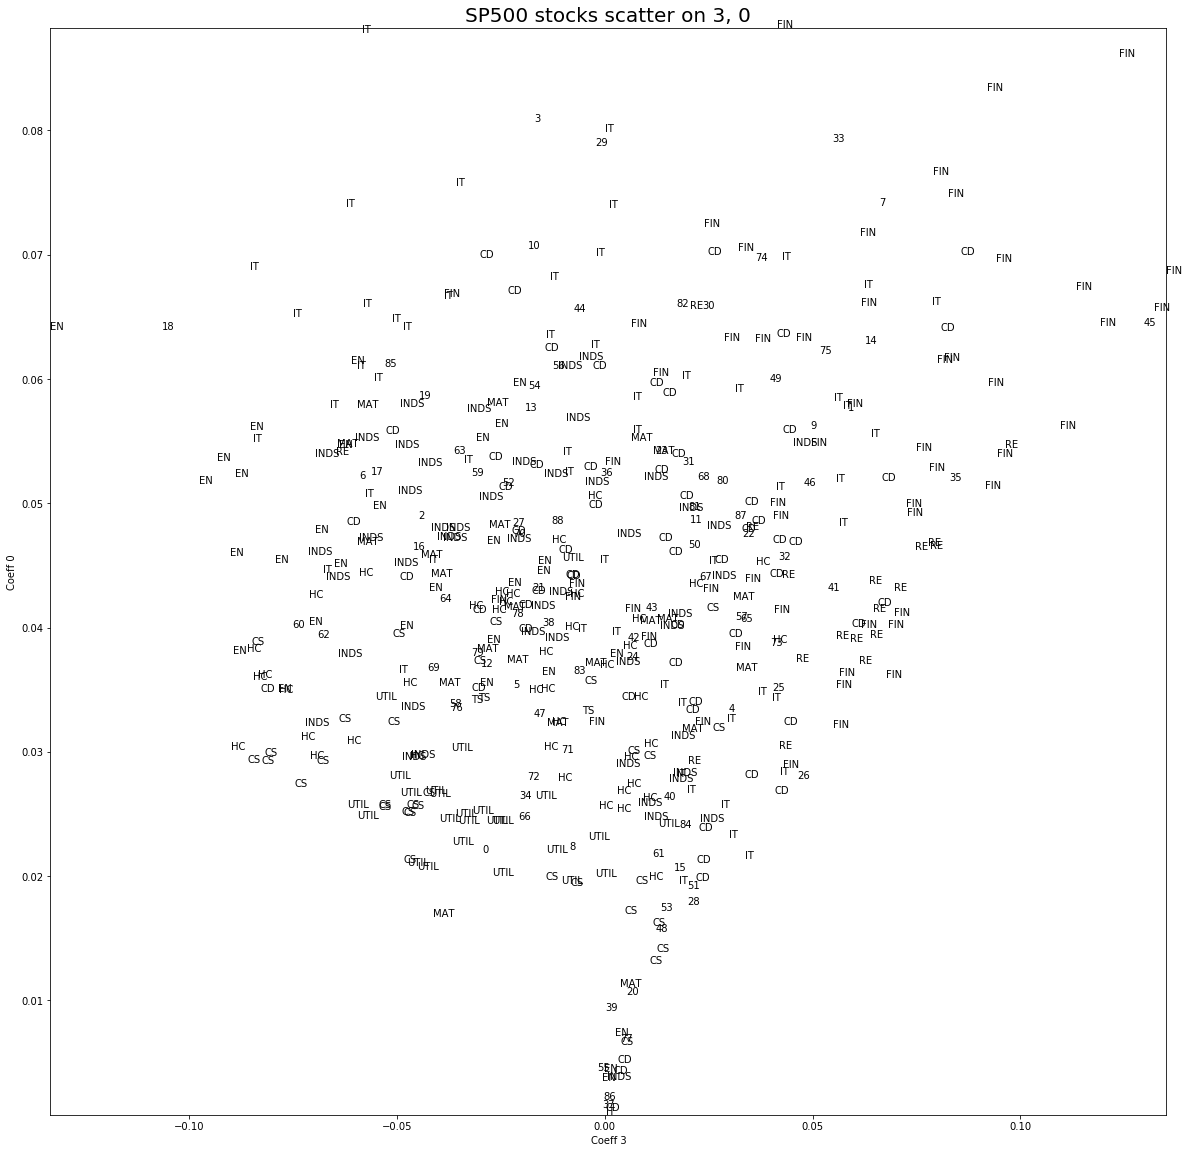

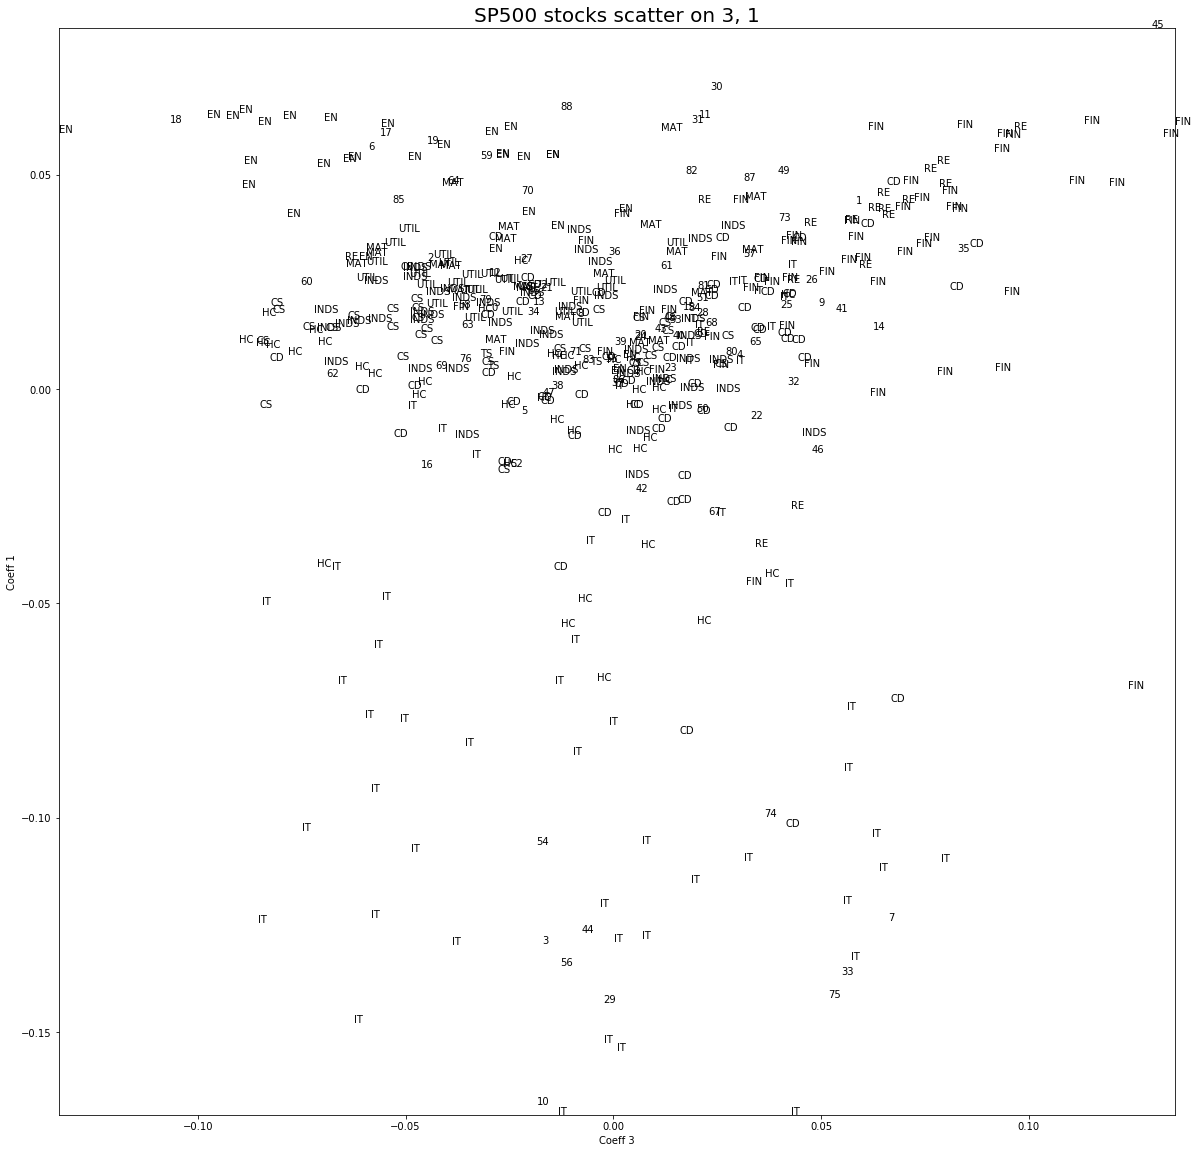

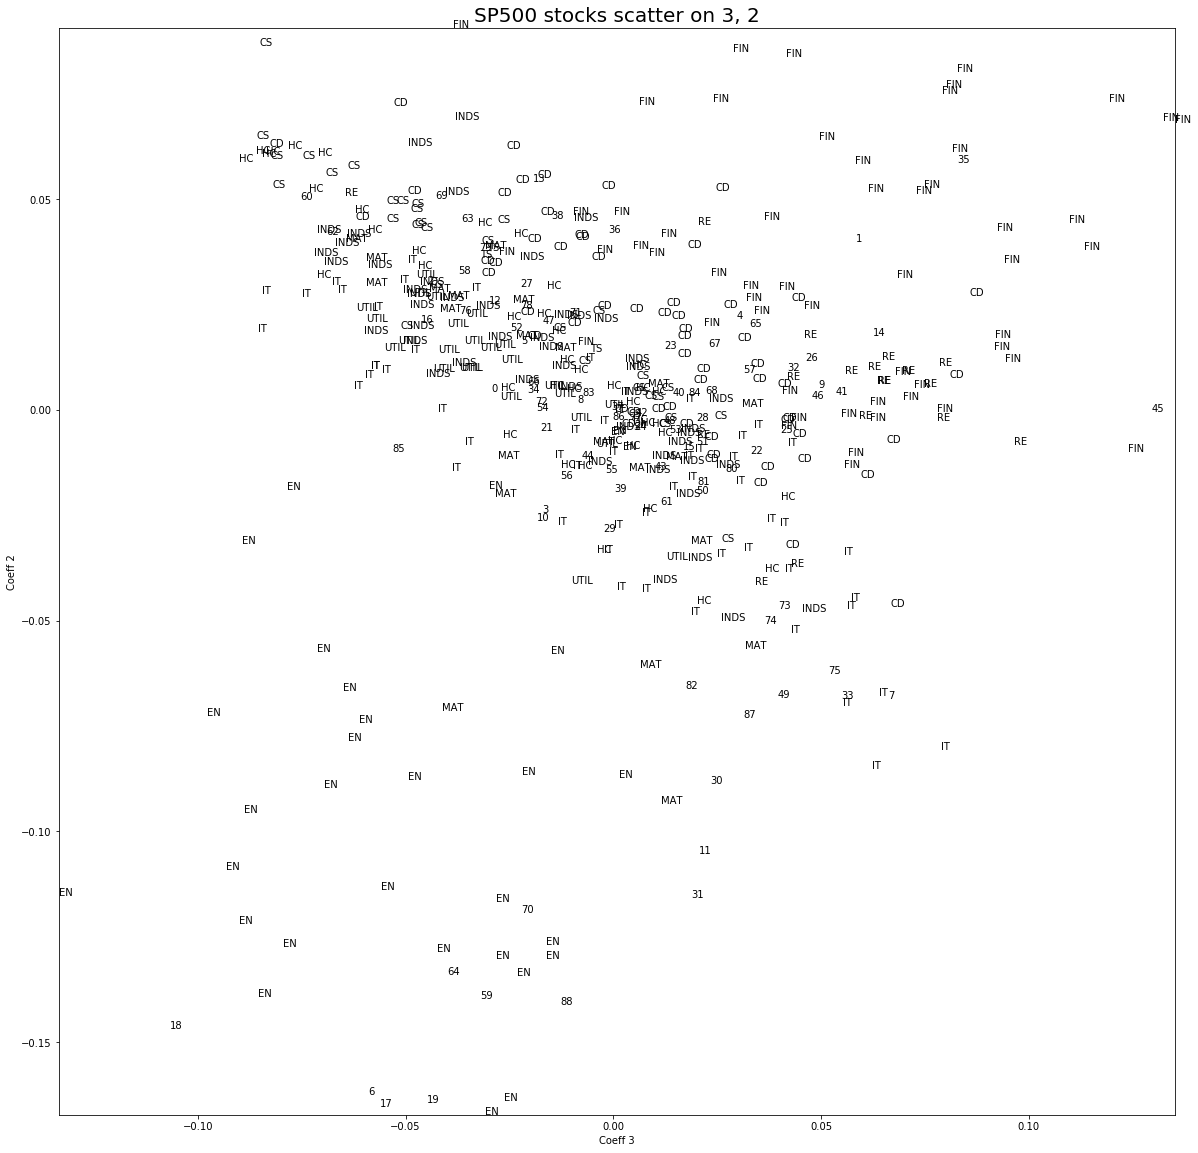

In [34]:
for i0 in range(4):
    for i1 in range(i0):
        print(i0,i1)
        Scatter_Stocks(eigval_all,eigvec_all,i0,i1);

## Check 
Check that your `figs/scatter.2.1.pdf` is similar to `figs/scatter.2.1.annotated.pdf`. Note that the orientation of the eigenvectors can be flipped.

Total points 50